In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [28]:
dataset = pd.read_csv("COVID_dataset_train.csv")

In [29]:
# replacing NaN in Outbreak_Related with NO 
dataset['Outbreak_Related'] = dataset['Outbreak_Related'].fillna("No") 

# Dropping NaN values in Age_Group, Test_reported_date and specimen_date
dataset = dataset.dropna()

In [30]:
dataset.Accurate_Episode_Date = pd.to_datetime(dataset.Accurate_Episode_Date)
dataset.Case_Reported_Date = pd.to_datetime(dataset.Case_Reported_Date)
dataset.Test_Reported_Date = pd.to_datetime(dataset.Test_Reported_Date)
dataset.Specimen_Date = pd.to_datetime(dataset.Specimen_Date)

dataset = dataset.drop(['Test_Reported_Date', 'Specimen_Date'],axis=1)

In [31]:
dataset.Case_Reported_Date = list(map(lambda x: x.timestamp(),dataset.Case_Reported_Date))
dataset.Accurate_Episode_Date = list(map(lambda x: x.timestamp(),dataset.Accurate_Episode_Date))

In [32]:
## encoding of target variable
dataset_target = dataset['Outcome1']
dataset_target = pd.DataFrame(dataset_target, columns = ['Outcome1'])

categorical_cols = ['Outcome1']

# Create the encoder.
encoder_1 = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False)

# Fit and transform encoder to X
array_hot_encoded_1 = encoder_1.fit_transform(dataset_target)

# convert it to a Data Frame
data_hot_encoded_1 = pd.DataFrame(array_hot_encoded_1, index=dataset_target.index)

# set column names of encoded dataframe
data_hot_encoded_1.columns = encoder_1.get_feature_names(categorical_cols)

dataset_target_1 = data_hot_encoded_1

In [33]:
## encoding of features
dataset_features = dataset.drop(['Outcome1'], axis = 1)

dataset_features['Age_Group'] = dataset_features['Age_Group'].replace({'<20': 1, '20s': 2, '30s': 3 , '40s': 4, '50s': 5, '60s': 6, '70s': 7, '80s': 8, '90s': 9})

categorical_cols = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']

# Create the encoder.
encoder = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False)

# Fit and transform encoder to X
array_hot_encoded = encoder.fit_transform(dataset_features[categorical_cols])

# convert it to a Data Frame
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dataset.index)

# set column names of encoded dataframe
data_hot_encoded.columns = encoder.get_feature_names(categorical_cols)

# concatenate other columns with the encoded columns to get the final datset
data_other_cols = dataset_features.drop(columns=categorical_cols)
dataset_temp = pd.concat([data_hot_encoded, data_other_cols], axis=1)
dataset_features = dataset_temp

In [34]:
# X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_target_1, test_size = 0.10)

In [35]:
X_train = dataset_features
y_train = dataset_target_1

In [36]:
from sklearn.preprocessing import StandardScaler
numeric_columns = ['Reporting_PHU_Longitude', 'Reporting_PHU_Latitude','Case_Reported_Date', 'Accurate_Episode_Date']

sc = StandardScaler()

X_train_scaled = X_train.copy()


X_train_scaled[numeric_columns] = sc.fit_transform(X_train[numeric_columns])


In [37]:
# X_test_scaled = X_test.copy()
# X_test_scaled[numeric_columns] = sc.transform(X_test[numeric_columns])

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

# INITIALING ANN
ann = tf.keras.models.Sequential()

# ADDING INPUT LAYER AND FIRST HIDDEN LAYER
ann.add(tf.keras.layers.Dense(units = 112, activation='relu'))
ann.add(Dropout(0.05))

# ADDING SECOND HIDDEN LAYER
ann.add(tf.keras.layers.Dense(units=448, activation='relu', kernel_regularizer=l2(0.001)))

# ADDING THIRD HIDDEN LAYER
ann.add(tf.keras.layers.Dense(units=56, activation='relu'))

# ADDING OUTPUT LAYER
ann.add(tf.keras.layers.Dense(units=3, activation='softmax'))

ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 10)

fitted_model = ann.fit(X_train_scaled, y_train, validation_split = 0.15, callbacks = [callback], epochs= 400, verbose=1)

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

390/390 [==============================] - 4s 11ms/step - loss: 0.5358 - accuracy: 0.8315 - val_loss: 0.3710 - val_accuracy: 0.8926
Epoch 2/400
390/390 [==============================] - 2s 6ms/step - loss: 0.3791 - accuracy: 0.8815 - val_loss: 0.3527 - val_accuracy: 0.8876
Epoch 3/400
390/390 [==============================] - 2s 6ms/step - loss: 0.3383 - accuracy: 0.8934 - val_loss: 0.3841 - val_accuracy: 0.8781
Epoch 4/400
390/390 [==============================] - 2s 6ms/step - loss: 0.3

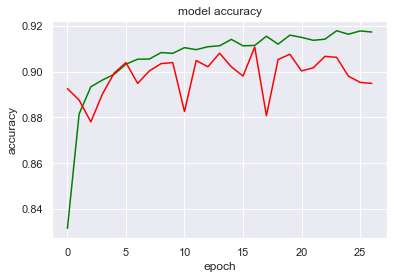

In [40]:
# summarize history for accuracy
plt.plot(fitted_model.history['accuracy'], c = 'green', label = 'acc')
plt.plot(fitted_model.history['val_accuracy'], c = 'red', label = 'val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

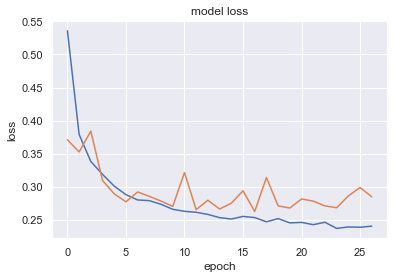

In [41]:
# summarize history for loss
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [42]:
# # FOR TESTING ON TRAINING SET

# # check test set accuracy
# results_train = ann.predict(X_test_scaled)

# pred_values_train= []
# for result in results_train:
#     entry = [0,0,0]
#     index = result.argmax()
#     entry[index] = 1
#     pred_values_train.append(entry)
    
# from sklearn.metrics import confusion_matrix, accuracy_score
# accuracy_score(y_test, pred_values_train)

In [43]:
dataset_test = pd.read_csv("COVID_dataset_test.csv")
dataset_test.head(5)

# replacing NaN in Outbreak_Related with NO 
dataset_test['Outbreak_Related'] = dataset_test['Outbreak_Related'].fillna("No") 

dataset_test.Accurate_Episode_Date = pd.to_datetime(dataset_test.Accurate_Episode_Date)
dataset_test.Case_Reported_Date = pd.to_datetime(dataset_test.Case_Reported_Date)
dataset_test.Test_Reported_Date = pd.to_datetime(dataset_test.Test_Reported_Date)
dataset_test.Specimen_Date = pd.to_datetime(dataset_test.Specimen_Date)

dataset_test = dataset_test.drop(['Test_Reported_Date', 'Specimen_Date'],axis=1)

dataset_test.Case_Reported_Date = list(map(lambda x: x.timestamp(),dataset_test.Case_Reported_Date))
dataset_test.Accurate_Episode_Date = list(map(lambda x: x.timestamp(),dataset_test.Accurate_Episode_Date))

dataset_test['Age_Group'] = dataset_test['Age_Group'].replace({'<20': 1, '20s': 2, '30s': 3 , '40s': 4, '50s': 5, '60s': 6, '70s': 7, '80s': 8, '90s': 9})

categorical_cols = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']

array_hot_encoded = encoder.transform(dataset_test[categorical_cols])

# convert it to a Data Frame
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dataset_test.index)

# set column names of encoded dataframe
data_hot_encoded.columns = encoder.get_feature_names(categorical_cols)

# concatenate other columns with the encoded columns to get the final datset
data_other_cols = dataset_test.drop(columns=categorical_cols)
dataset_temp = pd.concat([data_hot_encoded, data_other_cols], axis=1)

dataset_testing_final = dataset_temp.drop(['id'], axis = 1)

In [44]:
numeric_columns = ['Reporting_PHU_Longitude', 'Reporting_PHU_Latitude','Case_Reported_Date', 'Accurate_Episode_Date']

X_test_scaled = dataset_testing_final.copy()

X_test_scaled[numeric_columns] = sc.transform(dataset_testing_final[numeric_columns])

In [45]:
# check test set accuracy
results = ann.predict(X_test_scaled)

In [46]:
pred_values= []
for result in results:
    entry = [0,0,0]
    index = result.argmax()
    entry[index] = 1
    pred_values.append(entry)

In [47]:
result = []
for i in range(0, len(pred_values)):
    for j in range(3):
        if pred_values[i][j] == 1:
            if j == 0:
                result.append('Fatal')
            elif j == 1:
                result.append('Not Resolved')
            elif j == 2:
                result.append('Resolved')

In [48]:
output = pd.DataFrame(columns = ['Id','Outcome1'])
output['Id'] = dataset_test['id'] 
output['Outcome1'] = result

In [51]:
output.to_csv("Group_41_DATE_seconds_try3.csv", index = False)

In [52]:
output

,Id,Outcome1
0,0,Resolved
1,1,Resolved
2,2,Resolved
3,3,Fatal
4,4,Not Resolved
...,...,...
3699,3699,Not Resolved
3700,3700,Fatal
3701,3701,Resolved
3702,3702,Not Resolved
